In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

VER=1
#model_name = "jhu-clsp/ettin-encoder-1b"
model_name = "/kaggle/input/ettin-encoder-1b-offline/ettin-encoder-1b"

EPOCHS = 3

DIR = f"ver_{VER}"
os.makedirs(DIR, exist_ok=True)

In [37]:
import os
os.environ["WANDB_DISABLED"] = "true"   # fully disable
os.environ["WANDB_MODE"] = "disabled"   # belt & suspenders
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"


In [2]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train.csv')
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
n_classes = len(le.classes_)
print(f"Train shape: {train.shape} with {n_classes} target classes")
train.head()

Train shape: (36696, 9) with 65 target classes


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37


In [3]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [4]:
from IPython.display import display, Math, Latex

# GET ANSWER CHOICES
tmp = train.groupby(['QuestionId','MC_Answer']).size().reset_index(name='count')
tmp['rank'] = tmp.groupby('QuestionId')['count'].rank(method='dense', ascending=False).astype(int) - 1
tmp = tmp.drop('count',axis=1)
tmp = tmp.sort_values(['QuestionId','rank'])

# DISPLAY QUESTION AND ANSWER CHOICES
Q = tmp.QuestionId.unique()
for q in Q:
    question = train.loc[train.QuestionId==q].iloc[0].QuestionText
    choices = tmp.loc[tmp.QuestionId==q].MC_Answer.values
    labels="ABCD"
    choice_str = " ".join([f"({labels[i]}) {choice}" for i, choice in enumerate(choices)])
    
    print()
    display(Latex(f"QuestionId {q}: {question}") )
    display(Latex(f"MC Answers: {choice_str}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_LEN = 256

In [6]:
def format_input(row):
    x = "Yes"
    if not row['is_correct']:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct? {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct? Yes
Student Explanation: 0ne third is equal to tree nineth


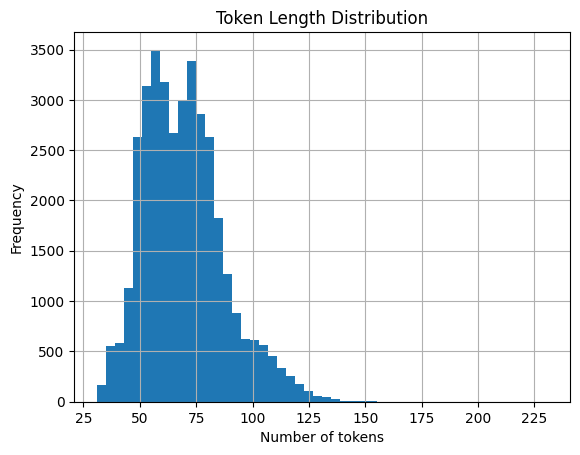

In [7]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [8]:
L = (np.array(lengths)>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort( lengths )

There are 0 train sample(s) with more than 256 tokens


array([ 31,  31,  31, ..., 178, 187, 231])

In [9]:
# Split into train and validation sets
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [42]:
# Cell 17 — replace tokenize with this
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding=True,          # <-- ensure SAME length in a batch
        truncation=True,
        max_length=256,
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)


Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=n_classes,
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True,
)

# Optional: PyTorch 2 compile
try:
    import torch
    model = torch.compile(model)
except Exception:
    pass


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/ettin-encoder-1b-offline/ettin-encoder-1b and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([35]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([35, 1792]) in the checkpoint and torch.Size([65, 1792]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
training_args = TrainingArguments(
    remove_unused_columns=False,
    report_to=[], # 👈 add this line
    output_dir = f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps",
    # ...rest of your arguments
)


In [17]:
# CUSTOM MAP@3 METRIC

from sklearn.metrics import average_precision_score

def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    
    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

In [31]:
training_args = TrainingArguments(
    remove_unused_columns=False,   # <-- put it here
    output_dir=f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
)


In [22]:
trainer.save_model(f"ver_{VER}")      
tokenizer.save_pretrained(f"ver_{VER}")

('ver_1/tokenizer_config.json',
 'ver_1/special_tokens_map.json',
 'ver_1/tokenizer.json')

In [23]:
test = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')
print( test.shape )
test.head()

(3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


In [24]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

test['text'] = test.apply(format_input,axis=1)

test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


In [43]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,   # <— helps with shapes
    compute_metrics=compute_map3,
)


/tmp/ipykernel_36/460083603.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
from transformers.integrations import WandbCallback
trainer.remove_callback(WandbCallback)


In [44]:
# Cell 23 — replace entire cell with this
import torch
from datasets import Dataset

# 1) Clean text
assert 'text' in test.columns, "Expected a 'text' column in test DataFrame"
test = test.copy()
test['text'] = test['text'].astype(str).fillna("").map(lambda x: x.strip())

# 2) HF Dataset
ds_test = Dataset.from_pandas(test[['text']].reset_index(drop=True))

# 3) Tokenize WITH padding/truncation
def _tokenize_pred(batch):
    return tokenizer(
        batch["text"],
        padding=True,
        truncation=True,
        max_length=256,
    )

ds_test = ds_test.map(_tokenize_pred, batched=True, remove_columns=["text"])

# 4) Keep only model inputs
keep_cols = [c for c in ["input_ids", "attention_mask", "token_type_ids"] if c in ds_test.column_names]
ds_test = ds_test.select_columns(keep_cols)

# 5) Torch format
ds_test.set_format(type='torch', columns=keep_cols)

# 6) Predict
pred = trainer.predict(ds_test)
logits = torch.tensor(pred.predictions)
probs = torch.softmax(logits, dim=1).numpy()
probs[:2], probs.shape


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

(array([[3.78912121e-01, 1.93122923e-02, 3.94599803e-04, 8.57687031e-04,
         3.36756604e-03, 8.06509634e-04, 3.08356388e-03, 3.99847375e-03,
         9.81570780e-03, 2.56096274e-02, 1.41844749e-02, 8.41634348e-03,
         1.41754339e-03, 3.81211145e-03, 6.44262589e-04, 7.74855667e-04,
         7.47580901e-02, 3.25956680e-02, 3.08563514e-03, 2.38788920e-03,
         2.81541552e-02, 4.55959176e-04, 3.25709139e-03, 1.04080318e-02,
         1.82132274e-02, 6.36661716e-05, 6.57611468e-04, 5.66566037e-03,
         6.95254770e-04, 7.09419604e-03, 1.33752369e-03, 1.61833670e-02,
         9.28286870e-04, 5.85836591e-03, 1.05926022e-02, 1.05101699e-02,
         6.69046445e-03, 4.92842356e-03, 1.19795706e-02, 4.10441384e-02,
         2.99114622e-02, 2.34685419e-03, 1.17346458e-03, 4.56584292e-03,
         4.84418968e-04, 2.37857969e-03, 5.52309267e-02, 1.10038128e-02,
         3.66482921e-02, 3.15833720e-04, 3.30990879e-04, 1.60080625e-03,
         2.29585008e-03, 1.32084796e-02, 1.06845167

In [45]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,False_Correct:NA False_Misconception:Inverse_o...
1,36697,False_Correct:NA True_Misconception:Additive F...
2,36698,False_Correct:NA True_Misconception:FlipChange...
